#  Import necessary libraries

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Define file paths
video_files = {
    "A": "/content/VIDEO A.xlsx",
    "B": "/content/VIDEO B.xlsx",
    "C": "/content/VIDEO C.xlsx",
    "D": "/content/VIDEO D.xlsx",
    "E": "/content/VIDEO E.xlsx",
    "F": "/content/VIDEO F.xlsx"
}

video_data = {}
for video, file_path in video_files.items():
    video_data[video] = pd.read_excel(file_path, sheet_name=None)  # Load all sheets


summary = {video: {sheet: df.shape for sheet, df in data.items()} for video, data in video_data.items()}

summary
video_data

{'A': {'All':                        Video position (%)  \
  0                                       0   
  1                                       1   
  2                                       2   
  3                                       3   
  4                                       4   
  ..                                    ...   
  99                                     99   
  100                                   NaN   
  101                                   NaN   
  102  Every video position is 8.33 seconds   
  103                          Video link:    
  
                   Absolute audience retention (%)  \
  0                                          92.92   
  1                                           91.8   
  2                                          90.67   
  3                                          89.54   
  4                                          88.41   
  ..                                           ...   
  99                                       

# Tranform data to include all systematically

In [5]:
# Function to process the 'Subscribers and non-subscribers' sheet
def process_subscribers_and_non_subscribers(df):

    subscribed = df[df['Subscription status'] == 'Subscribed'][['Video position (%)', 'Absolute audience retention (%)']]

    not_subscribed = df[df['Subscription status'] == 'Not subscribed'][['Video position (%)', 'Absolute audience retention (%)']]


    combined = pd.merge(subscribed, not_subscribed, on='Video position (%)', suffixes=('_Subscribed', '_Not_Subscribed'))

    return combined

# Function to process the 'Organic and paid traffic' sheet
def process_organic_and_paid_traffic(df):

    organic = df[df['Audience type'] == 'Organic'][['Video position (%)', 'Absolute audience retention (%)']]

    combined = organic.rename(columns={'Absolute audience retention (%)': 'Absolute audience retention (%)_Organic'})

    return combined

# Function to process 'New and returning viewers' sheet
def process_new_and_returning_viewers(df):

    new_viewers = df[df['New and Returning Viewers'] == 'New viewers'][['Video position (%)', 'Absolute audience retention (%)']]

    returning_viewers = df[df['New and Returning Viewers'] == 'Returning viewers'][['Video position (%)', 'Absolute audience retention (%)']]


    combined = pd.merge(new_viewers, returning_viewers, on='Video position (%)', suffixes=('_New', '_Returning'))

    return combined

# Function to process 'Detailed activity' sheet
def process_detailed_activity(df):

    detailed_activity = df[['Video position (%)', 'Started watching', 'Stopped watching', 'Number of times each moment was seen']]
    return detailed_activity

# Function to process 'Main (ALL)' sheet
def process_main_all(df, video=None):

    main_all_data = df[['Video position (%)', 'Absolute audience retention (%)']]


    main_all_data['Absolute audience retention (%)'] = main_all_data['Absolute audience retention (%)'].fillna(method='ffill')

    if video:

        main_all_data['Video'] = video
    return main_all_data

# Function to process 'Organic' sheet
def process_organic(df):

    organic = df[['Video position (%)', 'Compared to other videos (%)']]
    return organic

# Process all sheets for each video
processed_data = {}
for video, data in video_data.items():
    processed_data[video] = {}


    if 'New and returning viewers' in data:
        processed_data[video]['New and Returning Viewers'] = process_new_and_returning_viewers(data['New and returning viewers'])


    if 'Subscribers and non-subscribers' in data:
        processed_data[video]['Subscribers and Non-Subscribers'] = process_subscribers_and_non_subscribers(data['Subscribers and non-subscribers'])

    if 'Organic and paid traffic' in data:
        processed_data[video]['Organic and Paid Traffic'] = process_organic_and_paid_traffic(data['Organic and paid traffic'])


    if 'Detailed activity' in data:
        processed_data[video]['Detailed Activity'] = process_detailed_activity(data['Detailed activity'])

    if 'All' in data:
        processed_data[video]['Main ALL'] = process_main_all(data['All'], video=video)


    if 'Organic' in data:
        processed_data[video]['Organic'] = process_organic(data['Organic'])


combined_data = pd.DataFrame()

# For each video, merge the processed data sheets one by one
for video, sheets in processed_data.items():

    video_df = sheets.get('New and Returning Viewers', pd.DataFrame())


    subscribers_df = sheets.get('Subscribers and Non-Subscribers', pd.DataFrame())
    if not subscribers_df.empty:
        video_df = pd.merge(video_df, subscribers_df, on='Video position (%)', how='left')


    traffic_df = sheets.get('Organic and Paid Traffic', pd.DataFrame())
    if not traffic_df.empty:
        video_df = pd.merge(video_df, traffic_df, on='Video position (%)', how='left')


    detailed_activity_df = sheets.get('Detailed Activity', pd.DataFrame())
    if not detailed_activity_df.empty:
        video_df = pd.merge(video_df, detailed_activity_df, on='Video position (%)', how='left')


    if 'Main ALL' in sheets:
        main_all_df = sheets['Main ALL']
        video_df = pd.merge(video_df, main_all_df, on='Video position (%)', how='left')


    organic_df = sheets.get('Organic', pd.DataFrame())
    if not organic_df.empty:
        video_df = pd.merge(video_df, organic_df, on='Video position (%)', how='left')


    video_df['Video'] = video


    combined_data = pd.concat([combined_data, video_df], ignore_index=True)


combined_data.to_csv("Final_Combined_Data.csv", index=False)
combined_data



<ipython-input-5-0e1918eceb0e>:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  main_all_data['Absolute audience retention (%)'] = main_all_data['Absolute audience retention (%)'].fillna(method='ffill')
<ipython-input-5-0e1918eceb0e>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_all_data['Absolute audience retention (%)'] = main_all_data['Absolute audience retention (%)'].fillna(method='ffill')
<ipython-input-5-0e1918eceb0e>:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  main_all_data['Absolute audience retention (%)'] = main_all_data['Absolute audience reten

,Video position (%),Absolute audience retention (%)_New,Absolute audience retention (%)_Returning,Absolute audience retention (%)_Subscribed,Absolute audience retention (%)_Not_Subscribed,Absolute audience retention (%)_Organic,Started watching,Stopped watching,Number of times each moment was seen,Absolute audience retention (%),Video,Compared to other videos (%)
0,0,113.38,100.07,100.08,112.98,109.33,994718,72931,4072362,92.92,A,NaN
1,1,88.49,86.60,87.54,90.60,89.72,9162,42508,3341969,91.8,A,NaN
2,2,82.84,82.39,84.14,87.24,86.35,6512,32640,3216226,90.67,A,NaN
3,3,83.51,81.08,82.32,85.21,84.39,5153,21380,3143374,89.54,A,NaN
4,4,76.42,79.20,81.46,84.20,83.40,3273,19753,3106550,88.41,A,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
595,95,35.48,50.07,50.16,47.25,48.05,66,2310,1818401,48.05,F,-28.72
596,96,35.17,49.70,49.75,46.84,47.64,80,3392,1802760,47.64,F,-32.87
597,97,34.19,49.34,49.38,46.53,47.31,479,133521,1790466,47.31,F,-37.05
598,98,22.60,37.02,35.05,31.52,32.50,379,111566,1230022,32.5,F,-40.16


# Exploratory data analysis

Missing Values Analysis:
                                                Missing Values  Percentage
Video position (%)                                           0         0.0
Absolute audience retention (%)_New                          0         0.0
Absolute audience retention (%)_Returning                    0         0.0
Absolute audience retention (%)_Subscribed                   0         0.0
Absolute audience retention (%)_Not_Subscribed               0         0.0
Absolute audience retention (%)_Organic                      0         0.0
Started watching                                             0         0.0
Stopped watching                                             0         0.0
Number of times each moment was seen                         0         0.0
Absolute audience retention (%)                              0         0.0
Compared to other videos (%)                                 6         1.0

Statistical Summary:
       Video position (%)  Absolute audience retentio

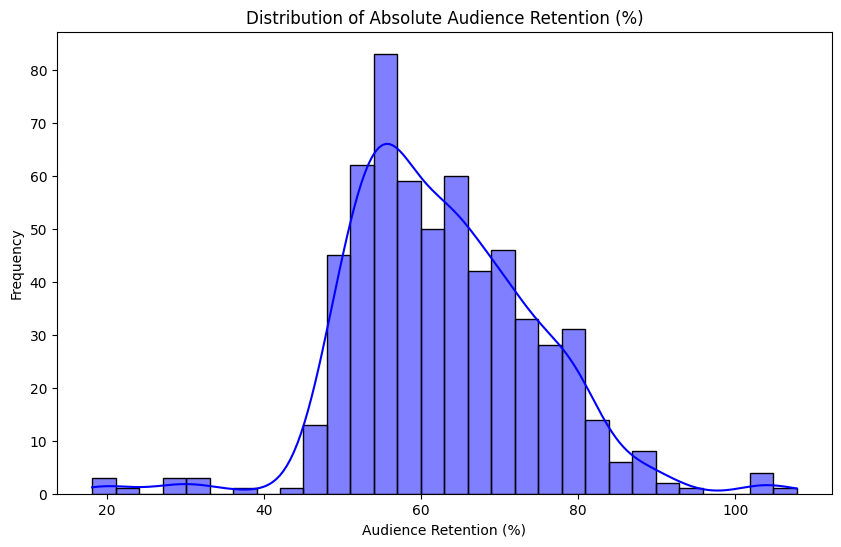

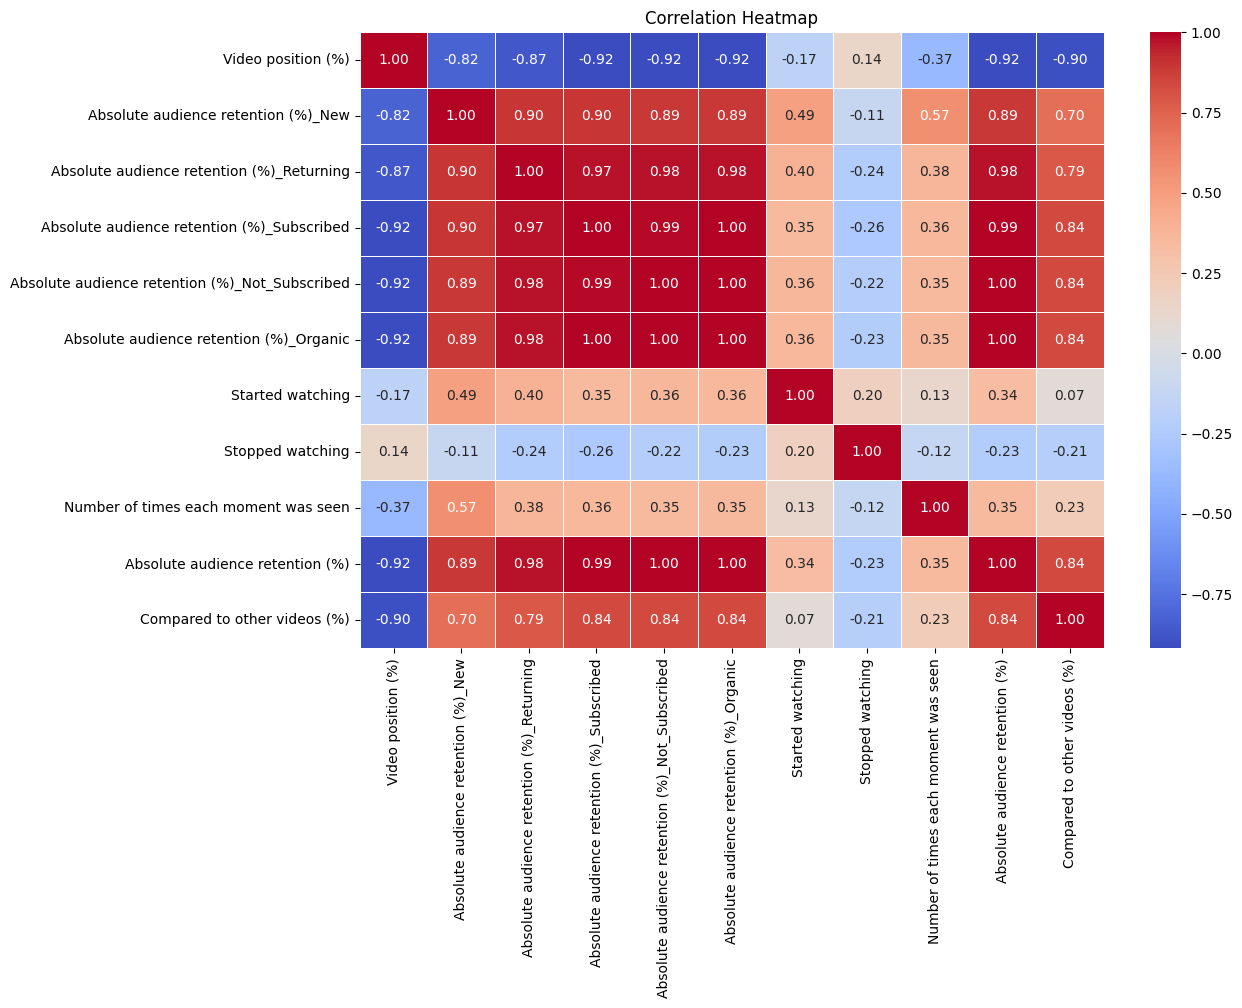

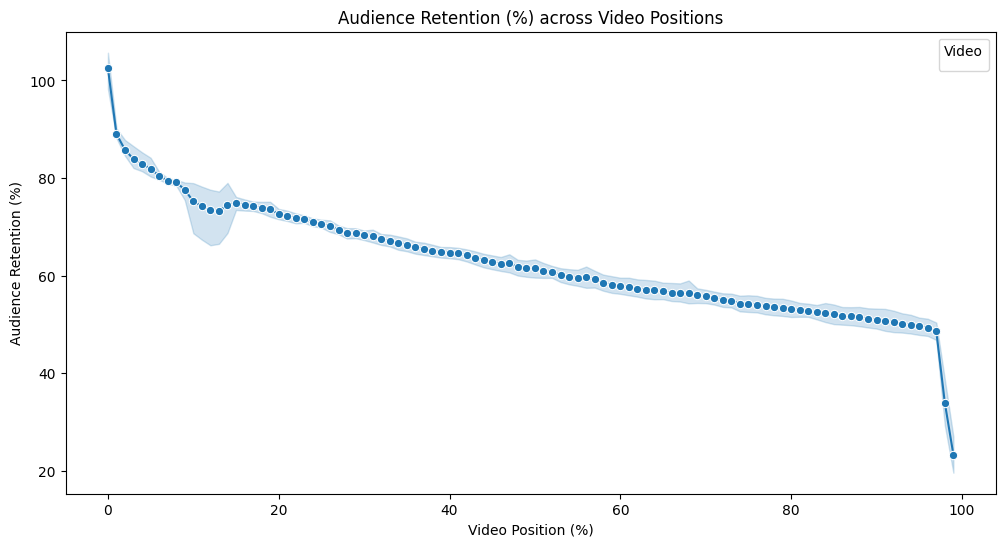

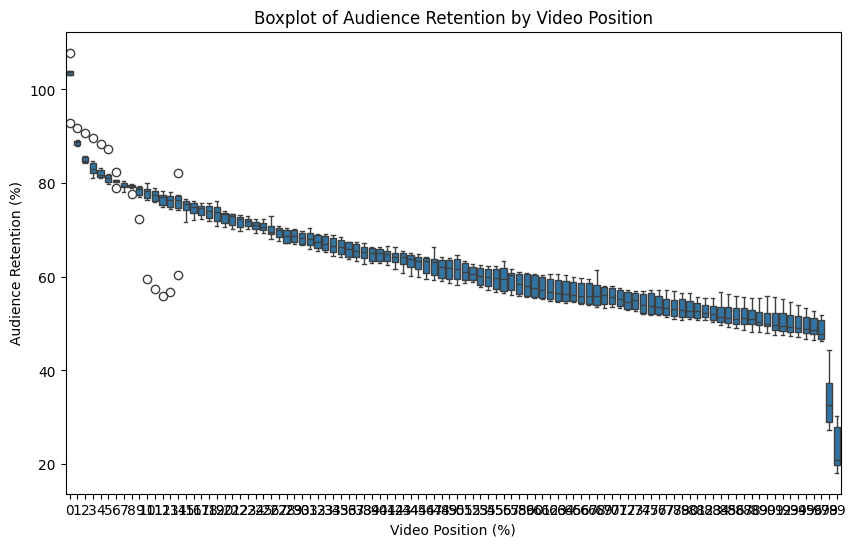

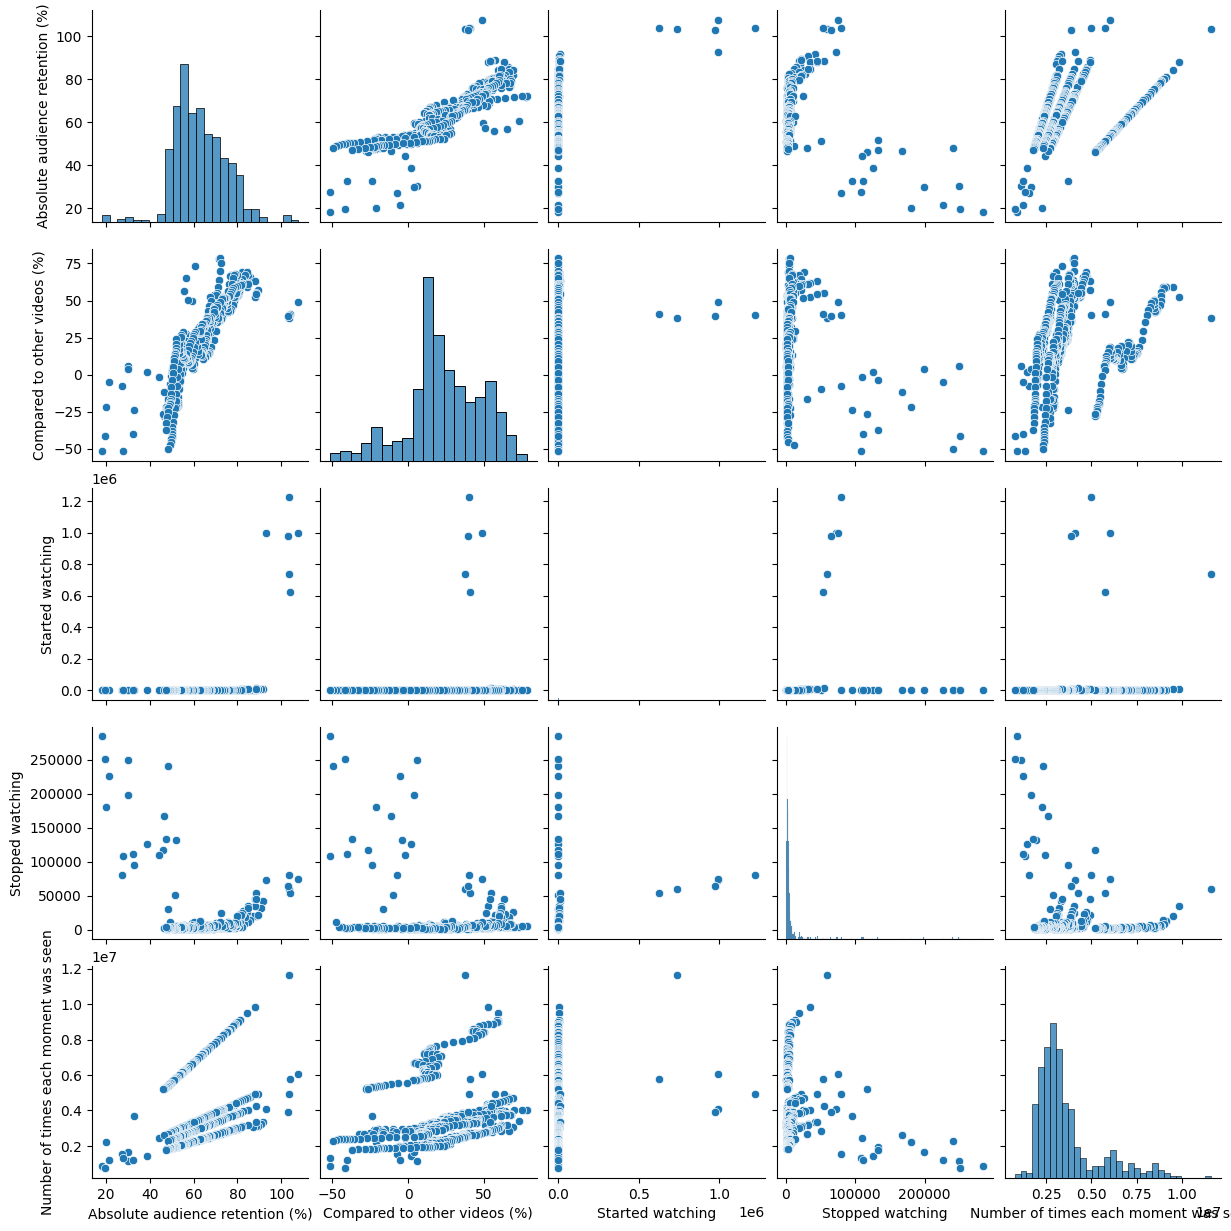

In [6]:

combined_data = pd.read_csv("Final_Combined_Data.csv")


combined_data = combined_data.drop(columns=['Video'])

# 1. Missing Values Analysis
missing_values = combined_data.isnull().sum()
missing_percentage = (missing_values / len(combined_data)) * 100
missing_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("Missing Values Analysis:")
print(missing_info)

# 2. Statistical Summary for Numeric Features
numeric_summary = combined_data.describe()
print("\nStatistical Summary:")
print(numeric_summary)

# 3. Distribution of 'Absolute audience retention (%)'

plt.figure(figsize=(10, 6))
sns.histplot(combined_data['Absolute audience retention (%)'], kde=True, bins=30, color='blue')
plt.title("Distribution of Absolute Audience Retention (%)")
plt.xlabel("Audience Retention (%)")
plt.ylabel("Frequency")
plt.show()

# 4. Correlation Analysis: Let's check correlations between numeric features
plt.figure(figsize=(12, 8))
corr_matrix = combined_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# 5. Visualization of retention percentage across different positions

plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_data, x='Video position (%)', y='Absolute audience retention (%)',  marker='o')
plt.title('Audience Retention (%) across Video Positions')
plt.xlabel('Video Position (%)')
plt.ylabel('Audience Retention (%)')
plt.legend(title='Video')
plt.show()

# 6. Boxplot to check for outliers in 'Absolute audience retention (%)'
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='Video position (%)', y='Absolute audience retention (%)')
plt.title('Boxplot of Audience Retention by Video Position')
plt.xlabel('Video Position (%)')
plt.ylabel('Audience Retention (%)')
plt.show()

# 7. Pairplot (optional) for checking relationships between key features

selected_columns = ['Absolute audience retention (%)', 'Compared to other videos (%)', 'Started watching', 'Stopped watching', 'Number of times each moment was seen']
sns.pairplot(combined_data[selected_columns], height=2.5)
plt.show()


# Cleaning , normalization and outlier detection and handling

In [7]:


file_path = '/content/Final_Combined_Data.csv'
data = pd.read_csv(file_path)

# Reset Missing Values for Positions 0-5 in Video A
data.loc[
    (data['Video position (%)'] <= 5) & (data['Video'] == 'A'),
    ['Absolute audience retention (%)', 'Compared to other videos (%)']
] = np.nan

# Outlier Detection and Capping
def detect_and_cap_outliers(data, threshold=3):
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    z_scores = data[numeric_columns].apply(zscore, nan_policy='omit')
    for col in numeric_columns:
        data[col] = data[col].where(abs(z_scores[col]) <= threshold, data[col].median())
    return data

# Normalize Features
def normalize_features(data, exclude_columns=None):
    exclude_columns = exclude_columns or []
    numeric_columns = [
        col for col in data.select_dtypes(include=['float64', 'int64']).columns
        if col not in exclude_columns
    ]
    scaler = MinMaxScaler()
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
    return data


training_data = data[data['Video position (%)'] > 5].copy()
prediction_data = data[(data['Video position (%)'] <= 5) & (data['Video'] == 'A')].copy()


training_data = detect_and_cap_outliers(training_data)
training_data = normalize_features(training_data, exclude_columns=['Video position (%)'])


print(prediction_data[['Video position (%)', 'Absolute audience retention (%)', 'Compared to other videos (%)']])


training_data.to_csv("Processed_Training_Data.csv", index=False)
prediction_data.to_csv("Processed_Prediction_Data.csv", index=False)

print("Processed training and prediction data saved.")


   Video position (%)  Absolute audience retention (%)  \
0                   0                              NaN   
1                   1                              NaN   
2                   2                              NaN   
3                   3                              NaN   
4                   4                              NaN   
5                   5                              NaN   

   Compared to other videos (%)  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
5                           NaN  
Processed training and prediction data saved.


# Modeel Training and View prediction

In [10]:

training_file = "/content/Processed_Training_Data.csv"
prediction_file = "/content/Processed_Prediction_Data.csv"
training_data = pd.read_csv(training_file)
prediction_data = pd.read_csv(prediction_file)

# Data for Time Series and Trend Analysis
b_f_data = training_data[training_data['Video'] != 'A']
trend_data = b_f_data.groupby('Video position (%)')['Absolute audience retention (%)'].mean().reset_index()

# Fit a Linear Regression Model on Positions 6-99 for B-F
X_trend = trend_data[trend_data['Video position (%)'] > 5][['Video position (%)']]
y_trend = trend_data[trend_data['Video position (%)'] > 5]['Absolute audience retention (%)']

trend_model = LinearRegression()
trend_model.fit(X_trend, y_trend)

# Predict Retention for Positions 0-5 Based on the Trend
X_predict = pd.DataFrame({'Video position (%)': [0, 1, 2, 3, 4, 5]})
y_predict = trend_model.predict(X_predict)

# Adjust Predictions Using Graph Insights
graph_adjustments = [0.02, 0.015, 0.01, 0.005, 0, -0.005]
adjusted_predictions = y_predict + graph_adjustments


final_predictions = pd.DataFrame({
    'Video position (%)': X_predict['Video position (%)'],
    'Predicted Audience Retention (%)': adjusted_predictions
})

final_predictions.to_csv("Simple_Trend_Predictions_Positions_0_5.csv", index=False)


X_val = trend_data[trend_data['Video position (%)'] > 5][['Video position (%)']]
y_val = trend_data[trend_data['Video position (%)'] > 5]['Absolute audience retention (%)']
y_val_pred = trend_model.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

print("Predictions saved to 'Predictions_.csv'")

Validation MAE: 0.021726253578496
Validation RMSE: 0.037370667541727
Predictions saved to 'Predictions_.csv'
